# Basic regression: Predict fuel efficiency
### 참고 : https://www.tensorflow.org/tutorials/keras/regression


[2022년 7월3일 ~ 7월5일]

### 회귀모델을 활용하여 자동차 연비를 예측하기. 
- Auto MPG 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만듭니다. 이 기간에 출시된 자동차 정보를 모델에 제공하겠습니다. 이 정보에는 실린더 수, 배기량, 마력(horsepower), 공차 중량 같은 속성이 포함됩니다.

### 회귀란?
회귀(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적

### 필요모듈 불러오기

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


### 데이터 다운 및 불러오기

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

In [ ]:
raw_dataset = pd.read_csv(dataset_path, na_values="?", names=column_names,comment='\t',sep=" ",skipinitialspace=True)

'''
여기서 궁금할 수 있는점!
- 왜 na_values="?"
  - csv에 "?" 로 값이 들어가있는 경우가 있다. 해당 경우를 불러올때 null 값으로 불러와 처리 할 수 있도록 설정해주는 것.
        isnull() 함수를 사용해 null 처리를 하기위해서 사용
  

- 왜 sep=" "?  "," 하면 안되나??
  - 해당 csv에서 각 값을들 빈 스패이스로 나눠두었기 때문에, 저렇게 설정 해줘야한다. default로는 ',' 를 사용함


- skiptinitialspace=True?? 이게 뭐지?
  -  Set the parameter to True to remove extra space.
  - 불필요한 빈칸이 있는경우 이상하게 값을 불러오게 된다. 


- comment?
  - In [11]: s = '# notes\na,b,c\n# more notes\n1,2,3'

    In [12]: pd.read_csv(StringIO(s), sep=',', comment='#', skiprows=1)
    Out[12]: 
        a   b   c
    0 NaN NaN NaN
    1   1   2   3 

'''

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 데이터 정제하기

주어진 데이터에 na값 확인

In [ ]:
dataset.isna().sum()

## horsepower 컬럼에서 6개의 null 값 확인됨

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
# 문제를 간단하게 만들기 위해서 누락된 행을 삭제
dataset = dataset.dropna()

In [ ]:
# "Origin" 열은 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환하겠습니다:
# 원-핫 인코딩 참고 : https://john-analyst.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A0%84%EC%B2%98%EB%A6%AC-%EB%A0%88%EC%9D%B4%EB%B8%94-%EC%9D%B8%EC%BD%94%EB%94%A9%EA%B3%BC-%EC%9B%90%ED%95%AB-%EC%9D%B8%EC%BD%94%EB%94%A9-f0220df21df1



# 기존 origin 컬럼 먼저 제거하면서 origin 변수로 빼오기
origin = dataset.pop('Origin')


# origin 함수를 보면서, 1 -> USA   2-> Europe 3-> Japan 컬럼으로 맞으면 1, 틀리면 0 추가 진행

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 훈련을 위해 데이터셋 분할 해주기

In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)    # 0.8을 학습 세트로 설정 , radom_state 설정하여 해당 코드가 사용될때마다 동일한 방법으로 데이터들을 나눠주기
test_dataset = dataset.drop(train_dataset.index)          # train_dataset으로 분류된 인덱스 제외한 나머지를 test_dataset으로 사용

### 데이터 조사하기

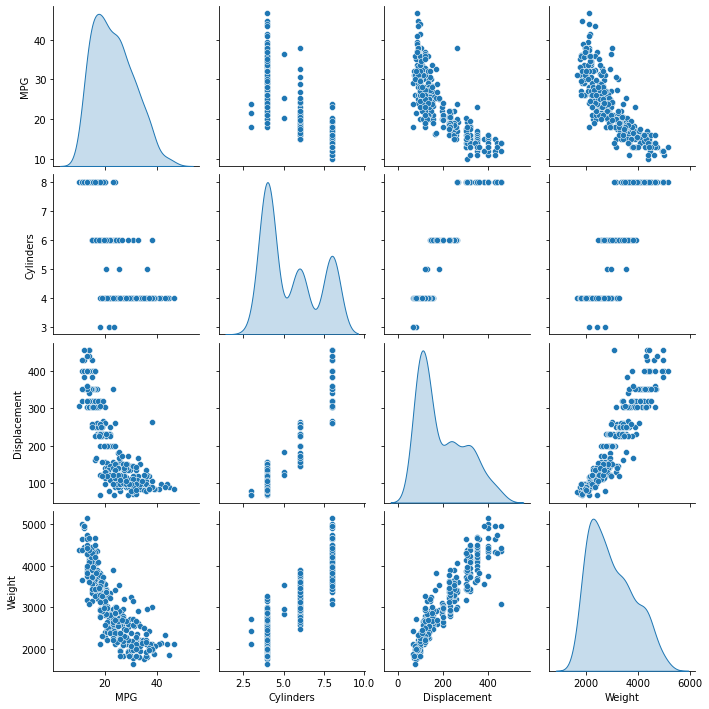

In [ ]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [ ]:
# 학습에서 사용할 레이블을 제거 및 레이블 변수로 저장

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 데이터 정규화

참고 데이터 정규화의 필요성 : https://hyen4110.tistory.com/20

<br>

특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됩니다. 특성을 정규화하지 않아도 모델이 수렴할 수 있지만, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

In [ ]:
## standard scaler 방식 사용 (평균과 편차를 사용)

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

'''
주의: 여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용되어야 합니다. 여기에는 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함됩니다.
'''

'\n주의: 여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용되어야 합니다. 여기에는 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함됩니다.\n'

## 모델 만들기

모델을 구성해 보죠. 여기에서는 두 개의 완전 연결(densely connected) 은닉층으로 Sequential 모델을 만들겠습니다. 
<br>
<br>
출력 층은 하나의 연속적인 값을 반환합니다. 나중에 두 번째 모델을 만들기 쉽도록 build_model 함수로 모델 구성 단계를 감싸겠습니다.

<br>

### 참고 [인공지능] ANN, DNN, CNN, RNN 개념과 차이 : https://ebbnflow.tistory.com/119

In [ ]:
train_dataset.keys()

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

In [ ]:
def build_model():
  model=keras.Sequential(
      [
       layers.Dense(64, activation = 'relu', input_shape=[len(train_dataset.keys())]),  # train_dataset.keys 는 컬럼들 : Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration','Model Year', 'USA', 'Europe', 'Japan']
       layers.Dense(64, activation = 'relu'),
       layers.Dense(1)           # 하나의 값을 반환하도록 마지막 레이어는 1을 준다
      ]
  )

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae','mse'])
  
  return model


In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 
example_batch = normed_train_data[:10] # 10개 데이터 불러오가
example_result = model.predict(example_batch)
example_result

array([[-0.18330097],
       [-0.01819389],
       [-0.6906305 ],
       [-0.03392556],
       [-0.02927279],
       [-0.07419395],
       [ 0.0298606 ],
       [ 0.0025523 ],
       [-0.17936772],
       [ 0.08541662]], dtype=float32)

In [ ]:
class PrintDot(keras.callbacks.Callback):  # 콜백함수를 만들어서 매 epoch 때마다 . 출력하게 만들기
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [ ]:

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [ ]:
# 학습 과정을 저장한 히스토리 데이터를 시각화 해보자
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.298855,0.955258,2.298855,10.758701,2.506425,10.758701,995
996,2.172893,0.926865,2.172893,10.499202,2.384091,10.499202,996
997,2.302468,0.935361,2.302468,11.580962,2.619583,11.580962,997
998,2.342923,0.925661,2.342923,10.465987,2.420606,10.465987,998
999,2.300672,0.972458,2.300672,10.556832,2.450385,10.556832,999


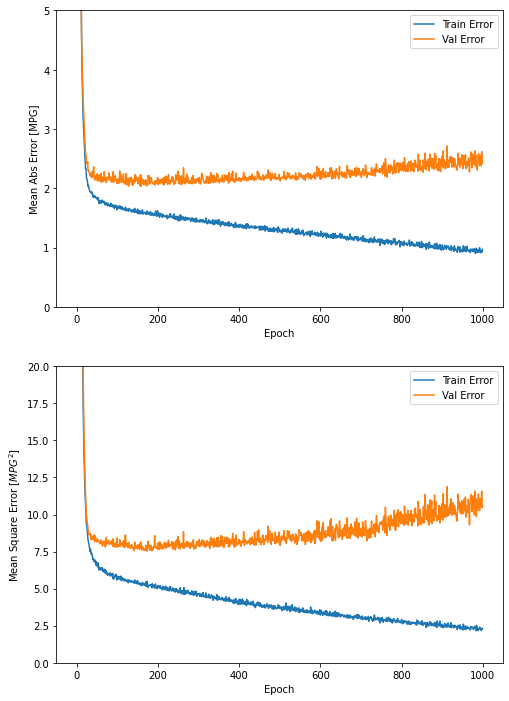

In [ ]:
# 해당 학습과정에서는 설정한 대로 'loss' "mae" "mse" 포함하고 있다
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


이 그래프를 보면 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 않는 것 같습니다.
model.fit 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어 보죠.
에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 콜백(callback)을 사용하겠습니다.
지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.




.....................................................................

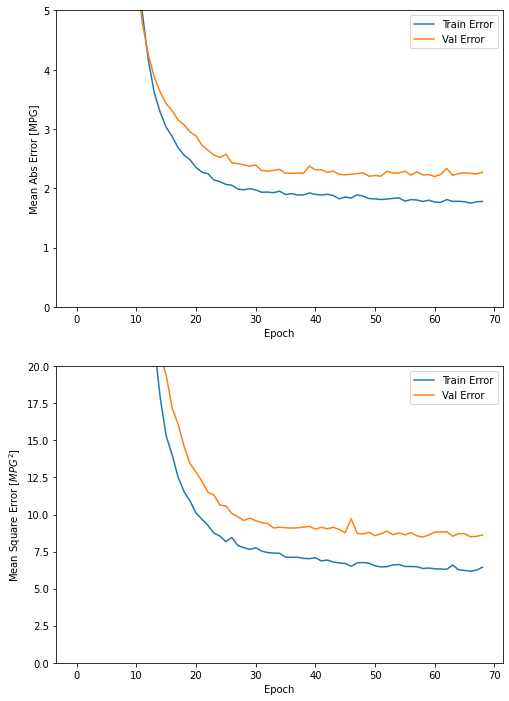

In [ ]:
# 콜백 추가하기

model = build_model()
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience=10)   # patience는 기준되는 값이 연속으로 몇 번 이상 향상되지 않을 때 종료시킬 것인지를 나타낸다.




history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])  # printdot 과 함께 콜백함수 추가

plot_history(history)

## 테스트 모델에 적용

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.7062 - mae: 1.7433 - mse: 5.7062 - 24ms/epoch - 8ms/step
테스트 세트의 평균 절대 오차:  1.74 MPG


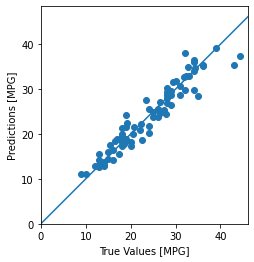

In [ ]:
# 마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해 보겠습니다:

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

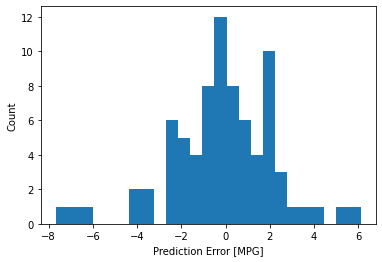

In [ ]:
# 오차분포 확인
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")